# U-Net Segmentation with PyTorch Lightning
### Lab: Implementing U-Net for Image Segmentation

**Goal**: Learn to use PyTorch Lightning to train a U-Net for image segmentation.

In this lab, we will build and train a U-Net model using PyTorch Lightning on a dataset for image segmentation.

**Dataset**: We will use the ISBI Cell Segmentation dataset.

---

In [ ]:
o

## 1. Installing Dependencies
You will need the following libraries:
- `pytorch-lightning`
- `torch`
- `torchvision`
- `opencv-python` (for image handling)
- `albumentations` (for data augmentation)

Install them using the following command:

In [ ]:
!pip install pytorch-lightning torch torchvision opencv-python albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.3 MB/s eta 0:00:00


## 2. Dataset Preparation
We will use the ISBI Cell Segmentation dataset. The following code defines a custom dataset class for loading images and their corresponding masks.

Make sure to replace `path_to_train_images` and `path_to_train_masks` with the actual dataset paths.

In [ ]:
!rm -rf ISBI-2012-challenge.zip
!rm -rf challenge-error-metrics.bsh
!rm -rf test-labels.tif
!rm -rf test-volume.tif
!rm -rf train-labels.tif
!rm -rf train-volume.tif
!rm -rf lightning_logs

!wget https://downloads.imagej.net/ISBI-2012-challenge.zip

!unzip ISBI-2012-challenge.zip

!mkdir ISBI-2012-challenge
!mv train-volume.tif train-labels.tif ISBI-2012-challenge/
!mv test-volume.tif test-labels.tif ISBI-2012-challenge/


--2024-11-23 18:09:45--  https://downloads.imagej.net/ISBI-2012-challenge.zip
Resolving downloads.imagej.net (downloads.imagej.net)... 144.92.48.183
Connecting to downloads.imagej.net (downloads.imagej.net)|144.92.48.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31487579 (30M) [application/zip]
Saving to: ‘ISBI-2012-challenge.zip’

ISBI-2012-challenge 100%[===================>]  30.03M  32.2MB/s    in 0.9s    

2024-11-23 18:09:46 (32.2 MB/s) - ‘ISBI-2012-challenge.zip’ saved [31487579/31487579]

Archive:  ISBI-2012-challenge.zip
mapname:  conversion of  failed
 extracting: test-volume.tif         
 extracting: test-labels.tif         
 extracting: train-labels.tif        
 extracting: train-volume.tif        
 extracting: challenge-error-metrics.bsh  


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Number of samples: 30
Image batch shape: torch.Size([4, 1, 128, 128]), Mask batch shape: torch.Size([4, 1, 128, 128])


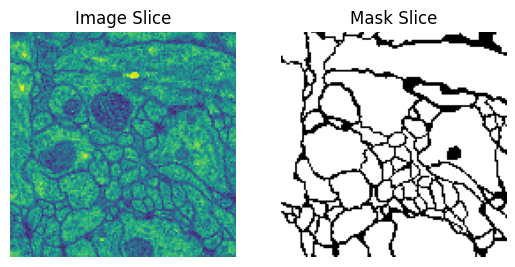

In [ ]:
import os
import numpy as np
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Custom dataset class for image segmentation
class ISBIDataset(Dataset):
    def __init__(self, volume_path, mask_path, transform=None):
        self.volume = tiff.imread(volume_path)  # Load the entire volume
        self.mask = tiff.imread(mask_path)      # Load the entire mask
        self.transform = transform
        self.num_slices = self.volume.shape[0]  # Get number of slices (assumes volume shape is (N, H, W))

    def __len__(self):
        return self.num_slices  # Return the number of slices

    def __getitem__(self, index):
        image = self.volume[index]  # Get the specific slice
        mask = self.mask[index]     # Get the corresponding mask slice

        # Normalize mask values from [0, 255] to [0, 1]
        mask = mask / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Apply transformations
            image = augmented['image']  # Transformed image
            mask = augmented['mask']    # Transformed mask

        return image, mask.unsqueeze(0)  # Add a single channel dimension to the mask


# Define transformations
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
])

# Load the dataset
train_dataset = ISBIDataset("./ISBI-2012-challenge/train-volume.tif",
                             "./ISBI-2012-challenge/train-labels.tif",
                             transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# What is the number of samples in the dataset?
num_samples = len(train_dataset)
print(f"Number of samples: {num_samples}")

# Print the shape of the first batch
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
    break  # Only print the shape of the first batch

# Using matplotlib to display the first image and mask
image = images[0].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
mask = masks[0].squeeze()           # Remove channel dimension if mask is single-channel

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image Slice")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask Slice")
plt.axis('off')

plt.show()


## 3. U-Net Model Architecture
We will now define the U-Net model. The following implementation has an encoder-decoder structure, which is suitable for segmentation tasks.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy

# Define the ConvBlock module for the U-Net model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# Define the Down module for the U-Net model
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv_block1 = ConvBlock(in_channels, out_channels)
        self.conv_block2 = ConvBlock(out_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.max_pool(x), x

# Define the Up module for the U-Net model
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block1 = ConvBlock(in_channels, out_channels)
        self.conv_block2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

# Define the final ConvBlock module for the U-Net model
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

from torchmetrics.classification import BinaryAccuracy

class UNetModule(pl.LightningModule):
    def __init__(self, in_channels=3, n_classes=1, n_filters=64, n_blocks=4):
        super(UNetModule, self).__init__()

        # Define the encoder path
        self.encoder = nn.ModuleList()
        for i in range(n_blocks):
            in_ch = in_channels if i == 0 else n_filters * (2 ** (i - 1))
            out_ch = n_filters * (2 ** i)
            self.encoder.append(Down(in_ch, out_ch))

        # Define the bottleneck path with two ConvBlock modules
        self.bottleneck = nn.Sequential(
            ConvBlock(n_filters * (2 ** (n_blocks - 1)), n_filters * (2 ** n_blocks)),
            ConvBlock(n_filters * (2 ** n_blocks), n_filters * (2 ** n_blocks))
        )

        # Define the decoder path
        self.decoder = nn.ModuleList()
        for i in range(n_blocks - 1, -1, -1):
            in_ch = n_filters * (2 ** (i + 1))
            out_ch = n_filters * (2 ** i)
            self.decoder.append(Up(in_ch, out_ch))

        # Define the output layer
        self.outconv = OutConv(n_filters, n_classes)

        # Accuracy metrics (for binary classification)
        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()

    def forward(self, x):
        skips = []
        for down in self.encoder:
            x, skip = down(x)
            skips.append(skip)

        x = self.bottleneck(x)

        for i, up in enumerate(self.decoder):
            x = up(x, skips[-(i + 1)])

        return self.outconv(x)

    # Training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        # For binary classification, apply sigmoid and round the predictions
        preds = torch.sigmoid(logits)
        preds = torch.round(preds)

        # Convert masks to float for loss calculation
        y = y.float()

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(logits, y)

        # Calculate accuracy
        acc = self.train_accuracy(preds, y.int())

        # Log the loss and accuracy
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        # For binary classification, apply sigmoid and round the predictions
        preds = torch.sigmoid(logits)
        preds = torch.round(preds)

        # Convert masks to float for loss calculation
        y = y.float()

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(logits, y)

        # Calculate accuracy
        acc = self.val_accuracy(preds, y.int())

        # Log validation loss and accuracy
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

        return loss


    # Optimizer setup
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



## 4. Training the Model
We can now train the U-Net model using PyTorch Lightning's `Trainer` class.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

# Define a callback to print accuracy at the end of training
class AccuracyCallback(Callback):
    def on_train_end(self, trainer, pl_module):
        # Get the final accuracy from the logs
        train_accuracy = trainer.callback_metrics.get('train_accuracy')
        print(f"Final Training Accuracy: {train_accuracy:.4f}")

# Initialize the U-Net model with 1 input channel
model = UNetModule(in_channels=1)

# Create a trainer with the AccuracyCallback
trainer = pl.Trainer(max_epochs=100, callbacks=[AccuracyCallback()])

# Train the model
trainer.fit(model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | encoder        | ModuleList     | 4.7 M  | train
1 | bottleneck     | Sequential     | 14.2 M | train
2 | decoder        | ModuleList     | 12.2 M | train
3 | outconv        | OutConv        | 65     | train
4 | train_accuracy | BinaryAccuracy | 0      | train
5 | val_accuracy   | BinaryAccuracy | 0      | train
----------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Final Training Accuracy: 0.9161


## 5. Evaluation and Visualization
We will now evaluate the model and visualize the segmentation results.

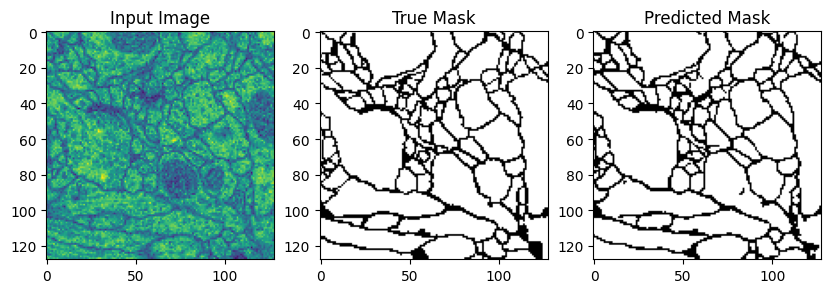

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(model, dataloader, threshold=0.5):
    model.eval()
    with torch.no_grad():
        for image, mask in dataloader:
            pred_mask = model(image)
            pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid to get values between 0 and 1
            pred_mask = (pred_mask > threshold).float()  # Apply threshold to binarize the mask

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].squeeze().cpu().numpy(), cmap="gray")
            plt.title("True Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask[0].squeeze().cpu().numpy(), cmap="gray")
            plt.title("Predicted Mask")
            plt.show()
            break


# Visualize a sample from the validation set
visualize_sample(model, train_loader)


## Conclusion
In this lab, we implemented a U-Net model for image segmentation using PyTorch Lightning. We trained the model on the ISBI Cell Segmentation dataset and visualized the segmentation results.

You can further improve the model by using a deeper U-Net architecture, adding more data augmentation techniques, and fine-tuning the hyperparameters.

sources :
https://github.com/WZH0120/SAM2-UNet/blob/main/sam2_configs/sam2_hiera_t.yaml